In [1]:
import numpy as np
import matplotlib.pyplot as plt
import unittest
from unittest import *
%matplotlib inline

## 2. Implement the 10-armed Testbed (see chapter 2.3 of [Sut17])
* Create an ipython notebook and solve the further exercises in this notebook.
* Provide a function def get_bandit_function(bandits_means, bandits_sigma=1) which gets the means of the bandits (bandits_means is a numpy array). The function should return a python function. The returned function gets an action as input and returns a sample reward for the action

In [2]:
def get_bandit_function(bandits_means, bandits_sigma=1):
    def bandit_function(action):
        if action >= 0 and action < len(bandits_means):
            return np.random.normal(bandits_means[action], bandits_sigma)
        else: 
            raise Exception("Wrong action: %s"%(action))
    return bandit_function

### Test for get_bandit_function

In [3]:
bandit_means = [-2.04402703, 0.78691329, -1.51854861, -0.74964035, 0.87538815, 1.51307674, 
                -1.43232683, -0.62838404, -0.03584927, -0.29624793]

In [4]:
bandit_function = get_bandit_function(bandit_means)
print(bandit_function(1))

1.200173255354302


In [5]:
arr = list()
for i in range(1000):
    arr.append(bandit_function(1))

(array([   5.,   28.,   97.,  177.,  231.,  255.,  140.,   54.,   11.,    2.]),
 array([-2.29674328, -1.64843883, -1.00013438, -0.35182993,  0.29647451,
         0.94477896,  1.59308341,  2.24138786,  2.88969231,  3.53799676,
         4.18630121]),
 <a list of 10 Patch objects>)

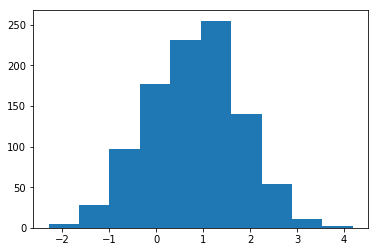

In [6]:
plt.hist(arr)

## 3. Implementation of a simple ϵ-greedy bandit algorithm
* Implement the action-value method (chapter 2.2 of [Sut17]) with the incremental implementation (chapter 2.4 of [Sut17]).
* Use the get_bandit_function.
* Use numpy build-in function for performance.

### calculate_avg
* calculate avg for n, with given avg for n-1

In [7]:
def calculate_avg(avg, n, value):
    return avg + (1 / n) * (value - avg) # bzw. ((avg * (n - 1)) + value) / n    

### Test for calculate_avg

In [8]:
class TestCalculateAvg(TestCase):
    def test_calculate_avg_1 (self):
        arr1 = np.array([1,2,3,4,5,6])
        arr2 = np.array([1,2,3,4,5])
        self.assertEqual(np.average(arr1), calculate_avg(np.average(arr2), (arr2.size + 1), 6))
        
    def test_calculate_avg_2 (self):
        arr1 = np.array([1])
        self.assertEqual(np.average(arr1), calculate_avg(0, 1, 1))
        
    def test_calculate_avg_3 (self):
        arr1 = np.array([0,0,0,1])
        self.assertEqual(np.average(arr1), calculate_avg(0, 4, 1))
        
    def test_calculate_avg_4 (self):
        self.assertEqual(1, calculate_avg(0, 1, 1))
        
    def test_calculate_avg_5 (self):
        arr1 = np.array([1])
        arr2 = np.array([])
        self.assertEqual(np.average(arr1), calculate_avg(0, (arr2.size + 1), 1))
    
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromModule(TestCalculateAvg()))

.....
----------------------------------------------------------------------
Ran 5 tests in 0.011s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

### calculate_q
* calculate q for n+1

In [9]:
def calculate_q(qn, n, rn):
    return calculate_avg(qn, n, rn) # bzw. qn + (1 / n) * (rn - qn)

### Test calculate_q

In [10]:
class TestCalculateQ(TestCase):
    def test_calculate_q_1 (self):
        self.assertEqual(calculate_q(0, 1, 3), 3.0)
    
    def test_calculate_q_2 (self):
        self.assertEqual(calculate_q(3.0, 2, 2), 2.5)
        
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromModule(TestCalculateQ()))

..
----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

### all_argmax
* returns all indexes of the maximum values of the given array

In [11]:
def all_argmax(arr):
    tmp_arr = np.array(arr)
    argmax_arr = np.array([], dtype=int)
    amax = np.amax(tmp_arr)
    for i in range(tmp_arr.size):
        if np.amax(tmp_arr) == amax:
            argmax_arr = np.append(argmax_arr, np.argmax(tmp_arr))
            tmp_arr[np.argmax(tmp_arr)] = np.amin(tmp_arr) - 1
        else:
            break
    return argmax_arr

### Test all_argmax

In [12]:
class TestAllArgmax(TestCase):
    def test_all_argmax_1(self):
        arr = all_argmax(np.array([0,0,0,0,0,1]))
        comp_arr = np.array([5])
        self.assertTrue((isinstance(arr, np.ndarray) and arr.shape == comp_arr.shape and 
            np.allclose(arr, comp_arr)))
    
    def test_all_argmax_2(self):
        arr = all_argmax(np.array([0,1,0,1,0,1]))
        comp_arr = np.array([1,3,5])
        self.assertTrue((isinstance(arr, np.ndarray) and arr.shape == comp_arr.shape and 
            np.allclose(arr, comp_arr)))
                         
    def test_all_argmax_3(self):
        arr = all_argmax(np.array([1,1,1,1,1,1]))
        comp_arr = np.array([0,1,2,3,4,5])
        self.assertTrue((isinstance(arr, np.ndarray) and arr.shape == comp_arr.shape and 
            np.allclose(arr, comp_arr)))
    
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromModule(TestAllArgmax()))

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### choose_action
* choose an action with regard to a specific epsilon

In [13]:
def choose_action(epsilon, qs):
    if (np.random.randint(0, 100, dtype=int) + 1) / 100 <= epsilon:
        return np.random.randint(0, qs.size, dtype=int)
    else:
        argmax_qs = all_argmax(qs) 
        return argmax_qs[np.random.randint(0, argmax_qs.size, dtype=int)]

### Test choose_action

In [14]:
class TestChooseAction(TestCase):
    def test_choose_action_1(self):
        self.assertEqual(choose_action(0, np.array([0,0,1])), 2)
        self.assertEqual(choose_action(0, np.array([0,1,0])), 1)
        self.assertEqual(choose_action(0, np.array([1,0,0])), 0)
        self.assertIn(choose_action(0, np.array([1,1,0])), [0,1])
        self.assertIn(choose_action(0, np.array([0,1,1])), [1,2])
        self.assertIn(choose_action(0, np.array([1,0,1])), [0,2])
        
    def test_choose_action_2(self):
        counter = 0
        for i in range(100000):
            if choose_action(1, np.array([0,1])) == 0:
                counter += 1  
        
        self.assertAlmostEqual((counter/100000), 0.5, places=2)
        
    def test_choose_action_3(self):
        counter = 0
        for i in range(100000):
            if choose_action(0.5, np.array([0,1])) == 0:
                counter += 1  
        
        self.assertAlmostEqual((counter/100000), 0.25, places=2)
        
        
        
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromModule(TestChooseAction()))

...
----------------------------------------------------------------------
Ran 3 tests in 6.841s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### get_average_rewards
* Compute the average reward and averaged percentage of using the optimal action for different 10-armed bandit problems

In [18]:
def get_average_rewards(epsilon=0.1, optimistic=0., nb_runs=2000, nb_steps=1000):
    """
    Compute the average reward for different 10-armed bandit problems.
    
    Parameters
    ----------
    epsilon : float
        epsilon: probability of chosing a random action (exploration).
    optimistic: float
        Initial value value of all action-values.
    nb_runs: int
        Number of runs with different 10-armed bandits for the averaging.
    nb_steps: int
        Number of steps. How often each bandit is played.
    
    Returns
    -------
    numpy array (dtype: double)
        averaged rewards. i-th element in the array contains the average reward at iteration step i.
    numpy array (dtype: double)
        averaged percentage of using the optimal action.
    """
    avg_optimal_action = np.zeros(nb_steps)
    avg_rewards = np.zeros(nb_steps)
    
    for run in range(nb_runs):
        bandit_means = np.random.normal(1, 1, 10)
        bandit_function = get_bandit_function(bandit_means)
        optimal_action = np.argmax(bandit_means)
        qs = np.array([[optimistic, optimistic, optimistic, optimistic, optimistic, 
                           optimistic, optimistic, optimistic, optimistic, optimistic],
                            np.ones(10)])
    
        for step in range(nb_steps):
            action = choose_action(epsilon, qs[0])
            if action == optimal_action:
                avg_optimal_action[step] = calculate_avg(avg_optimal_action[step], (run + 1), 1)
            else:
                avg_optimal_action[step] = calculate_avg(avg_optimal_action[step], (run + 1), 0)
            reward = bandit_function(action)
            avg_rewards[step] = calculate_avg(avg_rewards[step], (run + 2), reward)
            qs[0][action], qs[1][action] = calculate_q(qs[0][action], qs[1][action], reward), qs[1][action] + 1
    
    return avg_rewards, avg_optimal_action    

In [19]:
avg_rewards_e01, optimal_actions_e01 = get_average_rewards(epsilon=0.1, optimistic=0.)
avg_rewards_e005, optimal_actions_e005 = get_average_rewards(epsilon=0.05, optimistic=0.)
avg_rewards_e001, optimal_actions_e001 = get_average_rewards(epsilon=0.01, optimistic=0.)
avg_rewards_greedy, optimal_actions_greedy = get_average_rewards(epsilon=0, optimistic=0.)

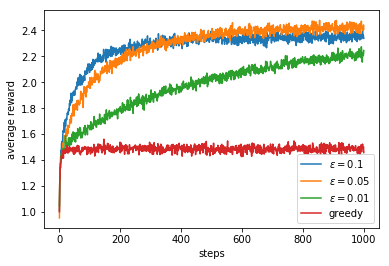

In [20]:
nb_steps = 1000
plt.plot(np.arange(nb_steps), avg_rewards_e01, label='$\epsilon=0.1$')
plt.plot(np.arange(nb_steps), avg_rewards_e005, label='$\epsilon=0.05$')
plt.plot(np.arange(nb_steps), avg_rewards_e001, label='$\epsilon=0.01$')
plt.plot(np.arange(nb_steps), avg_rewards_greedy, label='greedy')

plt.legend(loc=4)
plt.xlabel("steps")
plt.ylabel("average reward")

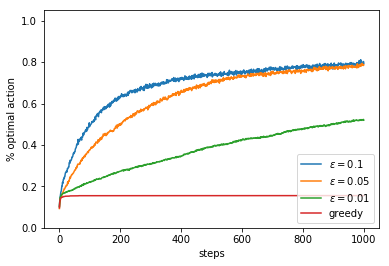

In [21]:
plt.plot(np.arange(nb_steps), optimal_actions_e01, label='$\epsilon=0.1$')
plt.plot(np.arange(nb_steps), optimal_actions_e005, label='$\epsilon=0.05$')
plt.plot(np.arange(nb_steps), optimal_actions_e001, label='$\epsilon=0.01$')
plt.plot(np.arange(nb_steps), optimal_actions_greedy, label='greedy')

plt.legend(loc=4)
plt.ylim(0., 1.05)
plt.xlabel("steps")
plt.ylabel("% optimal action")

### cumulative reward

In [22]:
cumulative_reward_e01 = np.sum(avg_rewards_e01)
cumulative_reward_e005 = np.sum(avg_rewards_e005)
cumulative_reward_e001 = np.sum(avg_rewards_e001)
cumulative_reward_greedy = np.sum(avg_rewards_greedy)

print("cumulative reward e=0.1: %s" %(cumulative_reward_e01))
print("cumulative reward e=0.05: %s" %(cumulative_reward_e005))
print("cumulative reward e=0.01: %s" %(cumulative_reward_e001))
print("cumulative reward e=0: %s" %(cumulative_reward_greedy))

cumulative reward e=0.1: 2269.73379776
cumulative reward e=0.05: 2273.81554682
cumulative reward e=0.01: 1970.82747075
cumulative reward e=0: 1484.60210994


### cumulative probability of selecting

In [23]:
cumulative_probability_of_selecting_e01 = np.sum(optimal_actions_e01)
cumulative_probability_of_selecting_e005 = np.sum(optimal_actions_e005)
cumulative_probability_of_selecting_e001 = np.sum(optimal_actions_e001)
cumulative_probability_of_selecting_greedy = np.sum(optimal_actions_greedy)

print("cumulative probability of selecting optimal action with e=0.1: %s" %(cumulative_probability_of_selecting_e01))
print("cumulative probability of selecting optimal action with e=0.05: %s" %(cumulative_probability_of_selecting_e005))
print("cumulative probability of selecting optimal action with e=0.01: %s" %(cumulative_probability_of_selecting_e001))
print("cumulative probability of selecting optimal action with e=0: %s" %(cumulative_probability_of_selecting_greedy))

cumulative probability of selecting optimal action with e=0.1: 686.5235
cumulative probability of selecting optimal action with e=0.05: 631.998
cumulative probability of selecting optimal action with e=0.01: 373.3985
cumulative probability of selecting optimal action with e=0: 155.183


### Optimistic Initial Values
All the methods we have discussed so far are **dependent to some extent on the initial action-value estimates**, Q1(a). In the language of statistics, these methods are **biased by their initial estimates**. For the sample-average methods, the bias disappears once all actions have been selected at least once, but for methods **with constant α, the bias is permanent**, though decreasing over time as given by (2.6). In practice, this kind of **bias is usually not a problem and can sometimes be very helpful**. The **downside** is that the initial estimates become, in effect, a set of parameters that **must be picked by the user**, if only to set them all to zero. The **upside** is that they provide an **easy way to supply some prior knowledge about what level of rewards can be expected**.
Initial action values can also be **used as a simple way of encouraging exploration**. Suppose that instead of setting the initial action values to zero, as we did in the 10-armed testbed, we set them all to +5. Recall that the q∗(a) in this problem are selected from a normal distribution with mean 0 and variance 1. An initial estimate of +5 is thus wildly optimistic. But this optimism encourages action-value methods to explore. Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to other actions, being “disappointed” with the rewards it is receiving. The result is that all actions are tried several times before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time.

In [24]:
avg_rewards_e01_optimistic, optimal_actions_e01_optimistic = get_average_rewards(epsilon=0.1, optimistic=5)

In [ ]:
plt.plot(np.arange(nb_steps), avg_rewards_e01, label='$\epsilon=0.1$ $optimistic=0$')
plt.plot(np.arange(nb_steps), avg_rewards_e01_optimistic, label='$\epsilon=0.1$ $optimistic=5$')

plt.legend(loc=4)
plt.xlabel("steps")
plt.ylabel("average reward")

In [ ]:
plt.plot(np.arange(nb_steps), optimal_actions_e01, label='$\epsilon=0.1$ $optimistic=0$')
plt.plot(np.arange(nb_steps), optimal_actions_e01_optimistic, label='$\epsilon=0.1$ $optimistic=5$')

plt.legend(loc=4)
plt.ylim(0., 1.05)
plt.xlabel("steps")
plt.ylabel("% optimal action")